# Phenotype acronym extraction

In [26]:
%load_ext autoreload
%autoreload 2

import sys
import cPickle
import numpy as np

# import snorkel and gwasdb
sys.path.append('../snorkel')
sys.path.append('../src')
sys.path.append('../src/crawler')

# set up paths
abstract_dir = '../data/db/papers'

# set up matplotlib
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load corpus

In [27]:
from snorkel.parser import XMLDocParser
from extractor.parser import UnicodeXMLTableDocParser

xml_parser = UnicodeXMLTableDocParser(
    path=abstract_dir,
    doc='./*',
    text='.//table',
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

In [28]:
from snorkel.parser import CorpusParser, OmniParser
import cPickle

table_parser = OmniParser()

corpus_name = 'gwas-table-corpus.pkl'
try:
    with open(corpus_name,"r") as pkl:
        corpus = cPickle.load(pkl)
except:
    cp = CorpusParser(xml_parser, table_parser, max_docs=15)
    %time corpus = cp.parse_corpus(name='GWAS Corpus')
    # pickling currently doesn't work...
#     with open(corpus_name,"w") as pkl:
#         corpus = cPickle.dump(corpus, pkl)

CPU times: user 54.7 s, sys: 2.99 s, total: 57.7 s
Wall time: 1min 24s


## Candidate extraction

### From tables

In [29]:
from snorkel.matchers import DictionaryMatch, Union, CellNameMatcher, CellDictNameMatcher
from snorkel.candidates import EntityExtractor
from snorkel.candidates import TableNgrams, CellSpace

# Define a candidate space
cells = CellSpace()

# Create a list of possible words that could denote phenotypes
acro_words = ['abbreviation', 'acronym']
phen_words = ['trait', 'phenotype']

# Define matchers
phen_matcher = CellDictNameMatcher(axis='col', d=phen_words, n_max=3, ignore_case=True)
acro_matcher = CellDictNameMatcher(axis='col', d=acro_words, n_max=3, ignore_case=True)

phen_extractor = EntityExtractor(cells, phen_matcher)
acro_extractor = EntityExtractor(cells, acro_matcher)

In [30]:
from snorkel.candidates import AlignedTableRelationExtractor
relation_extractor = AlignedTableRelationExtractor(phen_extractor, acro_extractor, axis='row', induced=False)
tables = corpus.get_tables()

In [31]:
%time candidates = relation_extractor.extract(tables, name='all')
print "%s relations extracted, e.g." % len(candidates)
for cand in candidates[:5]: 
    print cand

CPU times: user 23min 2s, sys: 11.2 s, total: 23min 13s
Wall time: 23min 20s
58 relations extracted, e.g.
SpanPair(Span("CD40 Ligand, serum & plasma", context=None, chars=[0,26], words=[0,5]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
SpanPair(Span("2", context=None, chars=[0,0], words=[0,0]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
SpanPair(Span("C-reactive protein", context=None, chars=[0,17], words=[0,1]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("5", context=None, chars=[0,0], words=[0,0]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("Intercellular adhesion molecule-1", context=None, chars=[0,32], words=[0,2]), Span("ICAM1", context=None, chars=[0,4], words=[0,0]))


In [32]:
for cand in candidates[:5]: 
    print cand.span0.context.table, cand

Table('17903293', 0) SpanPair(Span("CD40 Ligand, serum & plasma", context=None, chars=[0,26], words=[0,5]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
Table('17903293', 0) SpanPair(Span("2", context=None, chars=[0,0], words=[0,0]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
Table('17903293', 0) SpanPair(Span("C-reactive protein", context=None, chars=[0,17], words=[0,1]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
Table('17903293', 0) SpanPair(Span("5", context=None, chars=[0,0], words=[0,0]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
Table('17903293', 0) SpanPair(Span("Intercellular adhesion molecule-1", context=None, chars=[0,32], words=[0,2]), Span("ICAM1", context=None, chars=[0,4], words=[0,0]))


### From text

In [33]:
from snorkel.parser import SentenceParser, CorpusParser
from extractor.parser import UnicodeXMLDocParser, GWASXMLDocParser

xml_parser = GWASXMLDocParser(
    path=abstract_dir,
    doc='./*',
    title='.//front//article-title//text()',
    abstract='.//abstract//p//text()',
    par1='.//body/p[1]//text()',
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

sent_parser = SentenceParser()
cp = CorpusParser(xml_parser, sent_parser, max_docs=15)
%time text_corpus = cp.parse_corpus(name='GWAS Text Corpus')

CPU times: user 524 ms, sys: 145 ms, total: 668 ms
Wall time: 8.12 s


In [34]:
from snorkel.candidates import Ngrams
from snorkel.matchers import RegexMatchSpan
from snorkel.candidates import EntityExtractor, RelationExtractor

# Define a candidate space
ngrams6 = Ngrams(n_max=6)
ngrams3 = Ngrams(n_max=3)

# Define matchers
phen_matcher = RegexMatchSpan(rgx=r'.+ \([a-zA-Z]{0,5}[\);]')
acro_matcher = RegexMatchSpan(rgx=r'\([a-zA-Z]{0,5}[\);]')

# Extractors
phen_txt_extractor = EntityExtractor(ngrams6, phen_matcher)
acro_txt_extractor = EntityExtractor(ngrams3, acro_matcher)

# Filtering function
def overlap_filter_fn(span0, span1):
    start0, end0 = span0.char_start, span0.char_end
    start1, end1 = span1.char_start, span1.char_end
    return True if start0 <= start1 <= end1 <= end0 else False

# Relation extractor
txt_tab_extractor = RelationExtractor(phen_txt_extractor, acro_txt_extractor, filter_fn=overlap_filter_fn)

Extract acroynms from tables

In [35]:
S=corpus.get_phrases()
print len(S)
long_S = [s for s in S if not s.cell]
print long_S[0]

15369


IndexError: list index out of range

In [39]:
# %time txt_tab_c = acro_txt_extractor.extract(corpus.get_sentences(), name='all')
%time txt_tab_c = txt_tab_extractor.extract(corpus.get_phrases(), name='all')
print len(txt_tab_c), 'candidates extracted from text in tables'

CPU times: user 1.1 s, sys: 260 ms, total: 1.36 s
Wall time: 2 s
347 candidates extracted from text in tables


Extract acroynms from abstracts

In [41]:
%time txt_txt_c = txt_tab_extractor.extract(text_corpus.get_sentences(), name='all')
print len(txt_txt_c), 'candidates extracted from text in abstracts'

CPU times: user 753 ms, sys: 16.2 ms, total: 770 ms
Wall time: 781 ms
169 candidates extracted from text in abstracts


In [38]:
for cand in txt_tab_c[:100]:
    print cand.span0.context.document.name, cand

## Learning the correctness of relations

In [61]:
from snorkel.candidates import UnionExtractor

contexts = [corpus.get_tables(), corpus.get_sentences(), text_corpus.get_sentences()]
extractors = [relation_extractor, txt_tab_extractor, txt_tab_extractor]
joint_extractor = UnionExtractor(extractor_list=extractors, context_list=contexts)
all_c = joint_extractor.union()
print len(all_c)

### Creating a gold set

To create a gold set, we save all extracted relations into a csv file. We annotate it manually, and save the result to a second file. It contains pairs of phenotype and rsid strings; if that file exists, we take these as gold truth.

In [21]:
# store relations to annotate
with open('acronyms.unannotated.tsv', 'w') as f:
    for span_pair in all_c:
        doc_id = span_pair.span0.context.document.name
        str1 = span_pair.span0.get_span()
        str2 = span_pair.span1.get_span()
        try:
            f.write('%s\t%s\t%s\n' % (doc_id, str1, str2))
        except:
            continue

NameError: name 'all_c' is not defined

We now load the results of our annotation

In [42]:
annotations = dict()
with open('acronyms.anotated.txt') as f:
    text = f.read()
    for line in text.split('\r'):
        doc_id, str1, str2, res = line.strip().split('\t')
        res = 1 if int(res) == 1 else -1
        annotations[(doc_id, str1, str2)] = res

### Classifying table acronyms

In [43]:
from snorkel.features import TableNgramPairFeaturizer

pkl_f = 'acro_table_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = TableNgramPairFeaturizer()
    featurizer.fit_transform(candidates)

Building feature index...
Extracting features...
0/2579


In [44]:
def spair2uid(span_pair):
    doc_id = span_pair.span0.context.document.name
    str1 = span_pair.span0.get_span()
    str2 = span_pair.span1.get_span()
    return (doc_id, str1, str2)

# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(candidates)/2
for c in candidates[:n_half]:
    uid = spair2uid(c)
    if uid in annotations:
        gold_candidates.append(c)
        gold_labels.append(annotations[uid])
    else:
        training_candidates.append(c)
training_candidates.extend(candidates[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==-1])

Training set size: 30
Gold set size: 28
Positive labels in training set: 22
Negative labels in training set: 7
Positive labels in gold set: 14
Negative labels in gold set: 14


In [45]:
def LF1_digits(m):
    txt = m.span0.get_span()
    frac_num = len([ch for ch in txt if ch.isdigit()]) / float(len(txt))
    return -1 if frac_num > 0.5 else +1
def LF1_short(m):
    txt = m.span0.get_span()
    return -1 if len(txt) < 5 else 0

LF_tables = [LF1_digits, LF1_short]

In [46]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LF_tables, featurizer=TableNgramPairFeaturizer())

/Library/Python/2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Applying LFs...
Featurizing...
Building feature index...
Extracting features...
0/1926
LF Summary Statistics: 2 LFs applied to 30 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		100.00%
Overlap (candidates w/ > 1 labels):		23.33%
Conflict (candidates w/ conflicting labels):	0.00%


array([[<matplotlib.axes.AxesSubplot object at 0x12885efd0>]], dtype=object)

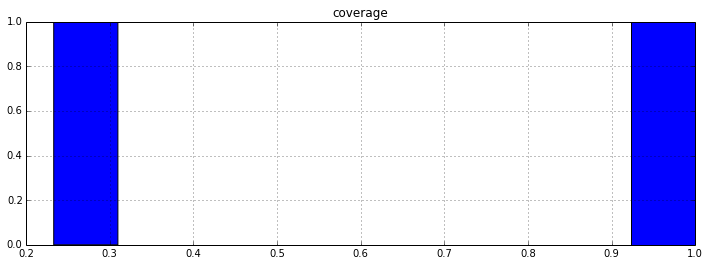

In [47]:
lf_stats = training_set.lf_stats()
lf_stats[:5]
lf_stats.hist("coverage")

In [48]:
from snorkel.snorkel import Learner
import snorkel.learning
from snorkel.learning import LogReg

learner = Learner(training_set, model=LogReg())

# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

from snorkel.learning_utils import GridSearch
gs       = GridSearch(learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.030888
	Learning epoch = 250	Gradient mag. = 0.084110
	Learning epoch = 500	Gradient mag. = 0.211097
	Learning epoch = 750	Gradient mag. = 0.275662
Final gradient magnitude for rate=0.01, mu=1e-05: 0.282
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.061684
	Learning epoch = 250	Gradient mag. = 0.158546
	Learning epoch = 500	Gradient mag. = 0.277430
	Learning epoch = 750	Gradient mag. = 0.284230
Final gradient magnitude for rate=0.01, mu=1e-05: 0.294
Testing mu = 1.00e-07, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.030888
	Learning epoch = 250	Gradient mag. = 0.084282
	Learning epoch = 500	Gradient mag. = 0.211653
	Learning epoch = 750	Gradient mag. = 0.275691
Final gradient magnitude for rate=0.01, mu=1e-07: 0.282
Testin

In [49]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,0.00001,1,1,1,1
1,0.00001,2,1,1,1
2,0.00000,1,1,1,1
3,0.00000,2,1,1,1


In [50]:
learner.test_wmv(test_candidates, test_labels)

Applying LFs...
Featurizing...
Test set size:	14
----------------------------------------
Precision:	1.0
Recall:		1.0
F1 Score:	1.0
----------------------------------------
TP: 7 | FP: 0 | TN: 7 | FN: 0


In [51]:
preds = learner.predict_wmv(candidates)
resolved_acronyms = [spair2uid(c) for (c, p) in zip(candidates, preds) if p == 1]
print resolved_acronyms[:10]

Applying LFs...
Featurizing...
[('17903293', u'CD40 Ligand, serum & plasma', u'CD40L'), ('17903293', u'C-reactive protein', u'CRP'), ('17903293', u'Intercellular adhesion molecule-1', u'ICAM1'), ('17903293', u'Interleukin-6', u'IL6'), ('17903293', u'Urinary isoprostanes/creatinine', u'IsoCrUrine'), ('17903293', u'Monocyte chemoattractant protein-1', u'MCP1'), ('17903293', u'Myeloperoxidase', u'MPO'), ('17903293', u'Osteoprotegerin', u'OPG'), ('17903293', u'P-selectin', u'Pselectin'), ('17903293', u'Tumor necrosis factor alpha', u'TNFA')]


In [52]:
# mislabeled_cand = learner.mislabeled_test_candidates(test_candidates, test_labels)
# for (c,p,g) in mislabeled_cand[:10]:
#     print c.span0.context.document.name
#     print c.span0.context    
#     print c.span1.context
#     print

### Classifying sentence acronyms

In [70]:
from snorkel.candidates import UnionExtractor

contexts = [corpus.get_phrases(), text_corpus.get_sentences()]
extractors = [txt_tab_extractor, txt_tab_extractor]
joint_extractor = UnionExtractor(extractor_list=extractors, context_list=contexts)
text_c = joint_extractor.union()
print len(text_c)

516


In [71]:
# helpers
def spairtxt2uid(span_pair):
    doc_id = span_pair.span0.context.document.name
    str1 = span_pair.span0.get_span()
    str2 = span_pair.span1.get_span()
    acro = str2[1:-1]
    phen = str1.split(' (')[0]
    return (doc_id, phen, acro)

We really trust the first stage, so if an acronym has been resolved there, remove it from this stage

In [72]:
new_text_c = list()
resolved = {(doc_id, acro) for doc_id, _, acro in resolved_acronyms}
for c in text_c:
    doc_id, phen, acro = spairtxt2uid(c)
    print doc_id, phen, acro
    if (doc_id, acro) not in resolved:
        new_text_c.append(c)

print len(new_text_c)

17903292 Glomerular Filtration Rate GFR
17903292 Glomerular Filtration Rate GFR
17903292 Filtration Rate GFR
17903292 Filtration Rate GFR
17903292 Glomerular Filtration Rate GFR
17903292 Rate GFR
17903292 Rate GFR
17903292 Filtration Rate GFR
17903292 Rate GFR
17903292 Thyroid stimulation hormone TSH
17903292 Thyroid stimulation hormone TSH
17903292 stimulation hormone TSH
17903292 stimulation hormone TSH
17903292 Thyroid stimulation hormone TSH
17903292 hormone TSH
17903292 hormone TSH
17903292 stimulation hormone TSH
17903292 hormone TSH
17903292 Follicle stimulating hormone FSH
17903292 stimulating hormone FSH
17903292 hormone FSH
17903292 Dehydroepiandrosterone sulfate DHEAS
17903292 sulfate DHEAS
17903292 on the web are GFRMV7 GFR
17903292 (GFR), UAELNMV6 GFR
17903292 (GFR), UAELNMV6 UAE
17903292 CysC), and TSHMEAN34MV TSH
17903292 , and TSHMEAN34MV TSH
17903292 , and TSHMEAN34MV TSH
17903292 the web are GFRMV7 GFR
17903292 GFR), UAELNMV6 UAE
17903292 ), and TSHMEAN34MV TSH
179032

In [73]:
from snorkel.features import NgramPairFeaturizer

pkl_f = 'acro_text_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = NgramPairFeaturizer()
    featurizer.fit_transform(text_c)

Building feature index...
Extracting features...
0/5970
5000/5970


In [74]:
# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(text_c)/2
for c in text_c[:n_half]:
    uid = spair2uid(c)
    if uid in annotations:
        gold_candidates.append(c)
        gold_labels.append(annotations[uid])
    else:
        training_candidates.append(c)
training_candidates.extend(text_c[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==-1])

Training set size: 300
Gold set size: 216
Positive labels in training set: 54
Negative labels in training set: 197
Positive labels in gold set: 28
Negative labels in gold set: 188


In [98]:
import re

# positive LFs
def LF_acro_matches(m):
    _, phen, acro = spairtxt2uid(m)
    words = phen.strip().split()
    if len(acro) == len(words):
        w_acro = ''.join([w[0] for w in words])
        if w_acro.lower() == acro.lower():
            return +1
    return 0

def LF_acro_matches_with_dashes(m):
    _, phen, acro = spairtxt2uid(m)
    words = re.split(' |-', phen.split())
    if len(acro) == len(words):
        w_acro = ''.join([w[0] for w in words])
        if w_acro.lower() == acro.lower():
            return +1
    return 0

def LF_acro_first_letter(m):
    _, phen, acro = spairtxt2uid(m)
    if not any(l.islower() for l in phen): return 0
    words = phen.strip().split()
    if len(acro) <= len(words):
        if words[0].lower() == acro[0].lower():
            return +1
    return 0

def LF_acro_second_letter(m):
    _, phen, acro = spairtxt2uid(m)
    if not any(l.islower() for l in phen): return 0
    if len(acro) < 4: return 0
    acro = acro[1:]
    words = phen.strip().split()
    if len(acro) <= len(words):
        if words[0].lower() == acro[0].lower():
            return +1
    return 0

# NOTE: not used
def LF_acro_second_letter(m):
    _, phen, acro = spairtxt2uid(m)
    if not any(l.islower() for l in phen): return 0
    if len(acro) < 4: return 0
    acro = acro[1:]
    words = phen.strip().split()
    if len(acro) <= len(words):
        if words[0].lower() == acro[0].lower():
            return +1
    return 0

def LF_acro_prefix(m):
    _, phen, acro = spairtxt2uid(m)
    phen = phen.replace('-', '')
    if phen[:2].lower() == acro[:2].lower():
        return +1
    return 0

def LF_acro_matches_last_letters(m):
    _, phen, acro = spairtxt2uid(m)
    words = phen.strip().split()
    for r in (1,2):
        new_acro = acro[r:]
        if len(new_acro) < 3: continue
        if len(new_acro) == len(words):
            w_acro = ''.join([w[0] for w in words])
            if w_acro.lower() == new_acro.lower():
                return +1
    return 0

LF_txt_pos = [LF_acro_matches, LF_acro_first_letter, LF_acro_prefix, LF_acro_matches_last_letters]

# negative LFs
def LF_no_pos(m):
    return -1 if not any(LF(m) for LF in LF_txt_pos) else 0

def LF_short(m):
    _, phen, acro = spairtxt2uid(m)
    return -1 if len(acro) == 1 else 0

def LF_lc(m):
    _, phen, acro = spairtxt2uid(m)
    return -1 if all(l.islower() for l in acro) else 0

def LF_uc(m):
    _, phen, acro = spairtxt2uid(m)
    return -1 if not any(l.islower() for l in phen) else 0

LF_txt_neg = [LF_no_pos, LF_short, LF_lc, LF_uc]

LF_txt = LF_txt_pos + LF_txt_neg

In [99]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LF_txt, featurizer=NgramPairFeaturizer())

Applying LFs...
Featurizing...
Building feature index...
Extracting features...
0/5260
5000/5260
LF Summary Statistics: 8 LFs applied to 300 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		100.00%
Overlap (candidates w/ > 1 labels):		20.67%
Conflict (candidates w/ conflicting labels):	0.00%


array([[<matplotlib.axes.AxesSubplot object at 0x128f4f190>]], dtype=object)

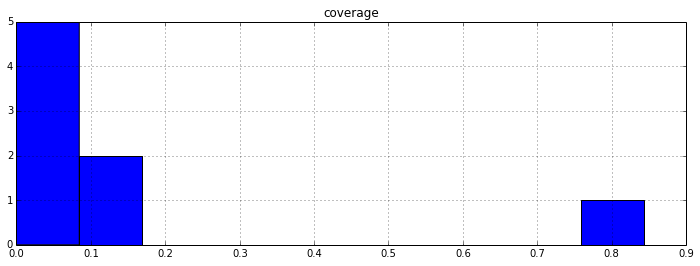

In [100]:
lf_stats = training_set.lf_stats()
lf_stats[:5]
lf_stats.hist("coverage")

In [101]:
from snorkel.snorkel import Learner
import snorkel.learning
from snorkel.learning import LogReg

text_learner = Learner(training_set, model=LogReg())

# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

from snorkel.learning_utils import GridSearch
gs       = GridSearch(text_learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.035677
	Learning epoch = 250	Gradient mag. = 0.044917
	Learning epoch = 500	Gradient mag. = 0.054043
	Learning epoch = 750	Gradient mag. = 0.065129
Final gradient magnitude for rate=0.01, mu=1e-05: 0.078
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.061755
	Learning epoch = 250	Gradient mag. = 0.072695
	Learning epoch = 500	Gradient mag. = 0.081157
	Learning epoch = 750	Gradient mag. = 0.090401
Final gradient magnitude for rate=0.01, mu=1e-05: 0.101
Testing mu = 1.00e-07, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.035677
	Learning epoch = 250	Gradient mag. = 0.044941
	Learning epoch = 500	Gradient mag. = 0.054095
	Learning epoch = 750	Gradient mag. = 0.065213
Final gradient magnitude for rate=0.01, mu=1e-07: 0.078
Testin

In [102]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,0.00001,1,0.647059,0.55,0.594595
1,0.00001,2,0.700000,0.70,0.700000
2,0.00000,1,0.647059,0.55,0.594595
3,0.00000,2,0.700000,0.70,0.700000


In [103]:
text_learner.test_wmv(test_candidates, test_labels)

Applying LFs...
Featurizing...
Test set size:	108
----------------------------------------
Precision:	1.0
Recall:		0.875
F1 Score:	0.933333333333
----------------------------------------
TP: 7 | FP: 0 | TN: 100 | FN: 1


In [104]:
text_preds = text_learner.predict_wmv(text_c)
text_acronyms = [spairtxt2uid(c) for (c, p) in zip(text_c, text_preds) if p == 1]
print text_acronyms[:10]
mislabeled_cand = [(c,p, annotations.get(spair2uid(c), None)) for c, p in zip(text_c, text_preds) if p != annotations.get(spair2uid(c), p)]
for (c,p,g) in mislabeled_cand[:50]:
    print c.span0.context.document.name, p, g
    print c.span0.context    
    print c.span0.get_span(), c.span1.get_span()
    print [LF(c) for LF in LF_txt]
    print

Applying LFs...
Featurizing...
[('17903292', u'Glomerular Filtration Rate', u'GFR'), ('17903292', u'Glomerular Filtration Rate', u'GFR'), ('17903292', u'Glomerular Filtration Rate', u'GFR'), ('17903292', u'Thyroid stimulation hormone', u'TSH'), ('17903292', u'Thyroid stimulation hormone', u'TSH'), ('17903292', u'Thyroid stimulation hormone', u'TSH'), ('17903292', u'Follicle stimulating hormone', u'FSH'), ('17903296', u'Bone mineral density', u'BMD'), ('17903296', u'Bone mineral density', u'BMD'), ('17903296', u'Bone mineral density', u'BMD')]
17903292 -1.0 1
Phrase('17903292', 0, 80, 0, u'Dehydroepiandrosterone sulfate (DHEAS)')
Dehydroepiandrosterone sulfate (DHEAS) (DHEAS)
[0, 0, 0, 0, -1, 0, 0, 0]

17903297 -1.0 1
Phrase('17903297', 0, 43, 0, u'Hippocampal Volume (AHPV)')
Hippocampal Volume (AHPV) (AHPV)
[0, 0, 0, 0, -1, 0, 0, 0]

17903297 -1.0 1
Phrase('17903297', 0, 87, 0, u'Boston Naming Test (Nam)')
Boston Naming Test (Nam) (Nam)
[0, 0, 0, 0, -1, 0, 0, 0]

17903297 -1.0 1
Phrase

### Collect all the candidates

In [107]:
table_preds = learner.predict_wmv(candidates)
table_acronyms = [spair2uid(c) for (c, p) in zip(candidates, preds) if p == 1]
print table_acronyms[:10]

text_preds = text_learner.predict_wmv(text_c)
text_acronyms = [spairtxt2uid(c) for (c, p) in zip(text_c, text_preds) if p == 1]
print text_acronyms[:10]

acronyms = table_acronyms + text_acronyms

Applying LFs...
Featurizing...
[('17903293', u'CD40 Ligand, serum & plasma', u'CD40L'), ('17903293', u'C-reactive protein', u'CRP'), ('17903293', u'Intercellular adhesion molecule-1', u'ICAM1'), ('17903293', u'Interleukin-6', u'IL6'), ('17903293', u'Urinary isoprostanes/creatinine', u'IsoCrUrine'), ('17903293', u'Monocyte chemoattractant protein-1', u'MCP1'), ('17903293', u'Myeloperoxidase', u'MPO'), ('17903293', u'Osteoprotegerin', u'OPG'), ('17903293', u'P-selectin', u'Pselectin'), ('17903293', u'Tumor necrosis factor alpha', u'TNFA')]
Applying LFs...
Featurizing...
[('17903292', u'Glomerular Filtration Rate', u'GFR'), ('17903292', u'Glomerular Filtration Rate', u'GFR'), ('17903292', u'Glomerular Filtration Rate', u'GFR'), ('17903292', u'Thyroid stimulation hormone', u'TSH'), ('17903292', u'Thyroid stimulation hormone', u'TSH'), ('17903292', u'Thyroid stimulation hormone', u'TSH'), ('17903292', u'Follicle stimulating hormone', u'FSH'), ('17903296', u'Bone mineral density', u'BMD'), (

In [108]:
# store relations to annotate
with open('acronyms.extracted.tsv', 'w') as f:
    for doc_id, str1, str2 in acronyms:
        f.write('%s\t%s\t%s\n' % (doc_id, str1, str2))